Introduces batch normalization

In [104]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [105]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [106]:
len(words)

32033

In [107]:
# building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [108]:
block_size = 3
# Building the dataset
def build_dataset(words):
    X,Y=[],[]

    for word in words:

        context = [0]*block_size
        for ch in word + '.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1=int(len(words)*0.8)
n2=int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])            #80%
Xdev, Ydev = build_dataset(words[n1:n2])        #10%
Xte, Yte = build_dataset(words[n2:])            #10%

In [109]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),                              generator=g)
w1 = torch.randn((n_embd * block_size, n_hidden),               generator=g)  * (5/3)/((n_embd * block_size) ** 0.5) # Formula for initializing weight of hidden layer for tan h
b1 = torch.randn((n_hidden),                                    generator=g)  * 0.01
w2 = torch.randn((n_hidden, vocab_size),                        generator=g)  * 0.01   # we initialize w2 to be small
b2 = torch.randn((vocab_size),                                  generator=g)  * 0    # we dont need to initialize b2

# We make those changes to w2 and b2 because thats how we get low initial loss and prevent the hockey stick effect
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running= torch.ones(1,n_hidden)

parameters = [w1,b1,w2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad= True

12027


In [ ]:
max_steps = 10000
batch_size = 32
lri = []
lossi = []
for i in range(max_steps):

    # Minibatch construction----------------------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass--------------------------------------------------
    emb = C[Xb]  # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # Concatenate the vectors
    hpreact = embcat @ w1 + b1

    # Batch norm layer ---------------------------------------------
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi +bnbias
    with torch.no_grad():
        bnmean_running =0.999 * bnmean_running +0.001 *bnmeani
        bnstd_running =0.999 * bnstd_running +0.001 *bnstdi
    # Non linearity-------------------------------------------------

    h = torch.tanh(hpreact)      
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # Backward pass--------------------------------------------------
    for p in parameters:
        p.grad = None
    loss.backward()

    # update---------------------------------------------------------
    # lr = lrs[i]
    lr= 0.1 if i < 6000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())




      0/  10000: 2.3436
   1000/  10000: 2.0953
   2000/  10000: 2.3401
   3000/  10000: 2.2631
   4000/  10000: 1.9857
   5000/  10000: 2.1090
   6000/  10000: 2.0529
   7000/  10000: 2.1189
   8000/  10000: 1.9992
   9000/  10000: 2.0991


In [112]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [113]:
# plt.hist(h.view(-1).tolist(),50)

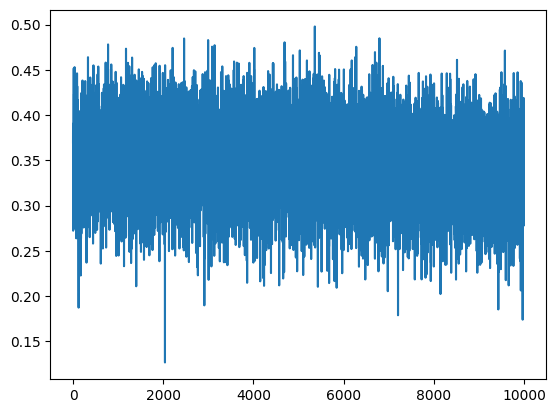

In [123]:
plt.plot(lossi)

In [124]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @w1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [126]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'dev': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * (hpreact - bnmean)/ bnstd +bnbias
    h=torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('dev')

train loss: 2.1564
dev loss: 2.1753


In [119]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        emb = C[torch.tensor(context)]
        embcat = emb.view(1, -1)
        h=torch.tanh(embcat @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1 ,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mrrahgmyazzreelmndhlyah.
remmrstengrlegraxxmyriel.
mullynnelleigh.
vangearvellynmorala.
nyshdgvrgxhzmin.
trin.
rwellelxnghuofyubergvdar.
jadulyeh.
ylayja.
shmyla.
haznavgyansuuwzalil.
juren.
crrvnsvevoen.
prrdxrnqyxmerbyggpril.
shmulyxh.
hurergmin.
jorivevordwrlla.
ortarmiz.
jedgsilv.
britgfrxvalyivin.
